In [1]:
!pip install torchmetrics

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, TensorDataset,random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os

In [3]:
# Load ground truth and reconstructed ellipse images
ground_truth_path = "/kaggle/input/ellipses-fullangle-128x128-4000/ground_truth_128dim_4000sz.pt"
recon_ellipses_path = "/kaggle/input/ellipses-fullangle-128x128-4000/recon_ellipses_128dim_4000s.pt"
ground_truth_images = torch.load(ground_truth_path)
reconstructed_images = torch.load(recon_ellipses_path)

# Reshaping images to [batch, channels, height, width]
ground_truth_images = ground_truth_images.view(-1,1,128,128)
reconstructed_images = reconstructed_images.view(-1,1,128,128) 

dataset = TensorDataset(reconstructed_images, ground_truth_images)

In [4]:
# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))   
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(test_dataset))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,drop_last=True)

3174
794


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi  

In [6]:
# class UNet(nn.Module):
#     """
#     U-Net model with an attention mechanism.
#     Parameters:
#         n_channels (int): Number of channels in the input image.
#         n_classes (int): Number of output classes.
#     """
#     def __init__(self, n_channels, n_classes):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes

#         # Encoder layers
#         self.initial_conv = DoubleConv(n_channels, 64)
#         self.downsample1 = nn.MaxPool2d(2)
#         self.conv_block1 = DoubleConv(64, 128)

#         # Attention Gate
#         self.attention_gate = AttentionGate(F_g=128, F_l=64, F_int=32)

#         # Decoder layers
#         self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
#         self.conv_block2 = DoubleConv(128, 64)
#         self.output_conv = nn.Conv2d(64, n_classes, kernel_size=1)

#     def forward(self, x):
#         # Encoder path
#         x1 = self.initial_conv(x)
#         x2 = self.downsample1(x1)
#         x3 = self.conv_block1(x2)

#         # Upsample and apply attention
#         x3_upsampled = F.interpolate(x3, size=x1.size()[2:], mode='bilinear', align_corners=True)
#         x3_with_attention = self.attention_gate(g=x3_upsampled, x=x1)

#         # Decoder path
#         x4 = torch.cat([x3_with_attention, x1], dim=1)
#         x5 = self.conv_block2(x4)

#         # Output layer
#         logits = self.output_conv(x5)
#         return logits 

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder layers
        self.initial_conv = DoubleConv(n_channels, 64)
        self.downsample1 = nn.MaxPool2d(2)
        self.conv_block1 = DoubleConv(64, 128)
        self.downsample2 = nn.MaxPool2d(2)
        self.conv_block2 = DoubleConv(128, 256)
        self.downsample3 = nn.MaxPool2d(2)
        self.conv_block3 = DoubleConv(256, 512)
        self.downsample4 = nn.MaxPool2d(2)
        self.conv_block4 = DoubleConv(512, 1024)

        # Decoder layers
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv_block5 = DoubleConv(1024, 512)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv_block6 = DoubleConv(512, 256)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv_block7 = DoubleConv(256, 128)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv_block8 = DoubleConv(128, 64)

        # Attention Gates for each upsampling path
        self.attention_gate1 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.attention_gate2 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.attention_gate3 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.attention_gate4 = AttentionGate(F_g=64, F_l=64, F_int=32)

        self.output_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder path
        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        x2 = self.conv_block1(x2)
        x3 = self.downsample2(x2)
        x3 = self.conv_block2(x3)
        x4 = self.downsample3(x3)
        x4 = self.conv_block3(x4)
        x5 = self.downsample4(x4)
        x5 = self.conv_block4(x5)

        # Decoder path
        x = self.upsample1(x5)
        x = torch.cat([x, self.attention_gate1(x4, x)], dim=1)
        x = self.conv_block5(x)

        x = self.upsample2(x)
        x = torch.cat([x, self.attention_gate2(x3, x)], dim=1)
        x = self.conv_block6(x)

        x = self.upsample3(x)
        x = torch.cat([x, self.attention_gate3(x2, x)], dim=1)
        x = self.conv_block7(x)

        x = self.upsample4(x)
        x = torch.cat([x, self.attention_gate4(x1, x)], dim=1)
        x = self.conv_block8(x)

        # Output layer
        logits = self.output_conv(x)
        return logits


In [8]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(1, 1).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

training_losses = []
num_epochs = 20
total_steps = len(train_loader) * num_epochs
progress_bar = tqdm(total=total_steps, desc='Training')

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        progress_bar.update(1)

    training_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

progress_bar.close()
torch.save(model.state_dict(), 'attunetonellipses4000.pth')

Training:   5%|▌         | 50/980 [00:22<08:42,  1.78it/s]

Epoch [1/20], Loss: 0.009187


Training:  10%|█         | 99/980 [00:44<08:15,  1.78it/s]

Epoch [2/20], Loss: 0.005844


Training:  15%|█▌        | 148/980 [01:06<07:47,  1.78it/s]

Epoch [3/20], Loss: 0.004434


Training:  20%|██        | 197/980 [01:28<07:19,  1.78it/s]

Epoch [4/20], Loss: 0.002501


Training:  25%|██▌       | 246/980 [01:50<06:52,  1.78it/s]

Epoch [5/20], Loss: 0.002014


Training:  30%|███       | 295/980 [02:12<06:24,  1.78it/s]

Epoch [6/20], Loss: 0.001591


Training:  35%|███▌      | 344/980 [02:34<05:57,  1.78it/s]

Epoch [7/20], Loss: 0.001500


Training:  40%|████      | 393/980 [02:56<05:29,  1.78it/s]

Epoch [8/20], Loss: 0.000678


Training:  45%|████▌     | 442/980 [03:18<05:02,  1.78it/s]

Epoch [9/20], Loss: 0.000710


Training:  50%|█████     | 491/980 [03:40<04:34,  1.78it/s]

Epoch [10/20], Loss: 0.000625


Training:  55%|█████▌    | 540/980 [04:02<04:07,  1.78it/s]

Epoch [11/20], Loss: 0.000657


Training:  60%|██████    | 589/980 [04:24<03:39,  1.78it/s]

Epoch [12/20], Loss: 0.000930


Training:  65%|██████▌   | 638/980 [04:46<03:12,  1.78it/s]

Epoch [13/20], Loss: 0.000486


Training:  70%|███████   | 687/980 [05:08<02:44,  1.78it/s]

Epoch [14/20], Loss: 0.000896


Training:  75%|███████▌  | 736/980 [05:30<02:16,  1.78it/s]

Epoch [15/20], Loss: 0.000609


Training:  80%|████████  | 785/980 [05:52<01:49,  1.78it/s]

Epoch [16/20], Loss: 0.000556


Training:  85%|████████▌ | 834/980 [06:14<01:22,  1.78it/s]

Epoch [17/20], Loss: 0.000636


Training:  90%|█████████ | 883/980 [06:36<00:54,  1.78it/s]

Epoch [18/20], Loss: 0.000437


Training:  95%|█████████▌| 932/980 [06:58<00:26,  1.78it/s]

Epoch [19/20], Loss: 0.000584


Training: 100%|██████████| 980/980 [07:20<00:00,  2.23it/s]

Epoch [20/20], Loss: 0.000716


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Average SSIM: 0.9523
Average PSNR: 36.2188
Average SSIM: 0.8904
Average PSNR: 26.5113


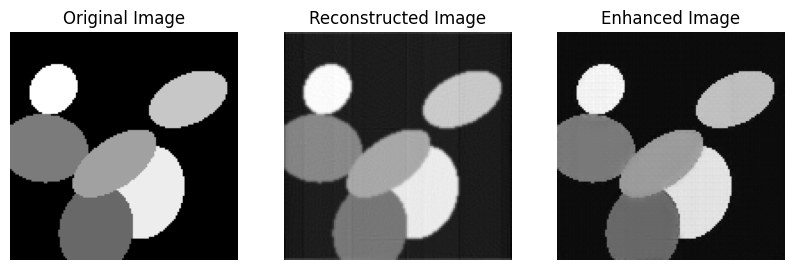

In [9]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Function to calculate SSIM for a batch of images
def batch_ssim(enhanced_images, ground_truth_images):
    ssim_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = ssim(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        ssim_scores.append(score)
    return np.mean(ssim_scores)

# Function to calculate PSNR for a batch of images
def batch_psnr(enhanced_images, ground_truth_images):
    psnr_scores = []
    for i in range(enhanced_images.size(0)):
        enhanced_np = enhanced_images[i].cpu().squeeze().numpy()
        gt_np = ground_truth_images[i].cpu().squeeze().numpy()
        score = psnr(enhanced_np, gt_np, data_range=gt_np.max() - gt_np.min())
        psnr_scores.append(score)
    return np.mean(psnr_scores)

# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')


In [10]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)

Total number of parameters:  31393901


In [11]:
print(model)

UNet(
  (initial_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (downsample1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block1): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [12]:
# Paths to the new dataset
ground_truth_path_new = "/kaggle/input/mayo-full181/Mayo_Full181_scaled_ground.pt"
recon_ellipses_path_new = "/kaggle/input/mayo-full181/Mayo_Full181_scaled_recon.pt"

# Load the images
ground_truth_images_new = torch.load(ground_truth_path_new)
reconstructed_images_new = torch.load(recon_ellipses_path_new)

print(ground_truth_images_new.shape)

# Reshape the images to [batch, channels, height, width]
ground_truth_images_new = ground_truth_images_new.view(-1, 1, 128, 128)
reconstructed_images_new = reconstructed_images_new.view(-1, 1, 128, 128)

# Create a dataset and DataLoader
dataset_new = TensorDataset(reconstructed_images_new, ground_truth_images_new)
loader_new = DataLoader(dataset_new, batch_size=64, shuffle=False)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/mayo-full181/Mayo_Full181_scaled_ground.pt'

In [ ]:
# Set model to training mode
model.train()

# Define a small learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Fine-tune the model
for inputs, targets in loader_new:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs.float())
    loss = criterion(outputs, targets.float())
    loss.backward()
    optimizer.step()


In [ ]:
# Evaluate the model and calculate SSIM and PSNR
model.eval()
all_ssim_scores = []
all_psnr_scores = []
recon_ssim = []
recon_psnr = []
printed = False
with torch.no_grad():
    for batch_reconstructed_images, batch_ground_truth_images in test_loader:
        batch_reconstructed_images = batch_reconstructed_images.to(device).float()
        batch_ground_truth_images = batch_ground_truth_images.to(device).float()
        enhanced_images = model(batch_reconstructed_images)
        if printed == False:
          printed = True
          plt.figure(figsize=(10,5))
          plt.subplot(131)
          plt.axis("off")
          plt.title("Original Image")
          plt.imshow(batch_ground_truth_images[0][0].cpu(),cmap='gray')
          plt.subplot(132)
          plt.axis("off")
          plt.title("Reconstructed Image")
          plt.imshow(batch_reconstructed_images[0][0].cpu(),cmap='gray')
          plt.subplot(133)
          plt.axis("off")
          plt.title("Enhanced Image")
          plt.imshow(enhanced_images[0][0].cpu(),cmap='gray')
        all_ssim_scores.append(batch_ssim(enhanced_images, batch_ground_truth_images))
        all_psnr_scores.append(batch_psnr(enhanced_images, batch_ground_truth_images))

        recon_ssim.append(batch_ssim(batch_reconstructed_images, batch_ground_truth_images))
        recon_psnr.append(batch_psnr(batch_reconstructed_images, batch_ground_truth_images))
        # break

# Calculate average SSIM and PSNR
avg_ssim = np.mean(all_ssim_scores)
avg_psnr = np.mean(all_psnr_scores)
rec_ssim = np.mean(recon_ssim)
rec_psnr = np.mean(recon_psnr)
print(f'Average SSIM: {avg_ssim:.4f}')
print(f'Average PSNR: {avg_psnr:.4f}')
print(f'Average SSIM: {rec_ssim:.4f}')
print(f'Average PSNR: {rec_psnr:.4f}')